# Import dependencies

In [ ]:
!pip install thermox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 MB 21.2 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33


In [ ]:
# import basic packages
import numpy as np
from numpy import linalg
import pandas as pd
import cvxopt
import pickle

from cvxopt.solvers import coneqp

# import thermox
import thermox
from thermox.utils import (
    handle_matrix_inputs,
    preprocess_drift_matrix,
    ProcessedDriftMatrix,
    ProcessedDiffusionMatrix,
)
from thermox.sampler import (
    sample,
    sample_identity_diffusion
)

# import jax
from jax.scipy.linalg import solve, inv, expm
import jax
import jax.numpy as jnp
from jax import Array, random

# sklearn
from sklearn import svm    # sklearn implementation of SVMs for comparison
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs

# import utilities
import tqdm
import warnings
import time

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# warnings.filterwarnings("ignore")
jax.config.update("jax_enable_x64", True)

# Ancillary functions

In [ ]:
def linear_kernel(x1, x2):
  return np.dot(x1, x2)

def gaussian_kernel(x1, x2, sigma=1.0):
  return np.exp(-linalg.norm(x1-x2)**2 / (2 * (sigma ** 2)))

def k_max_elements(lst, k):
    indices = np.argpartition(lst, -k)[-k:]
    result = [(lst[i], i) for i in indices]
    return sorted(result, reverse=True)

def plot_margin(X, y, model):

    x1_min = np.min(X[:,0])
    x1_max = np.max(X[:,0])
    x2_min = np.min(X[:,1])
    x2_max = np.max(X[:,1])

    xx = np.linspace(x1_min, x1_max)

    a = -model.w[0]/model.w[1]
    yy = a*xx - (model.b)/(model.w[1])

    margin = 1 / np.sqrt(np.sum(model.w**2))
    yy_neg = yy - np.sqrt(1 + a**2) * margin
    yy_pos = yy + np.sqrt(1 + a**2) * margin

    plt.figure(figsize=(5, 5))
    plt.plot(xx, yy, "b-")
    plt.plot(xx, yy_neg, "m--")
    plt.plot(xx, yy_pos, "m--")

    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=mpl.colors.ListedColormap(colors), edgecolors="black")
    plt.xlim(0.8*x1_min, 1.2*x1_max)
    plt.ylim(0.8*x2_min, 1.2*x2_max)

    plt.axis("tight")
    plt.show()

def time_vs_dim(data, solver_params, num_samples = 10000):
  times = {}
  params = {}
  models = {}
  train_error = {}

  times['fit_time_digital'] = np.zeros(len(data))
  times['fit_time_therm'] = np.zeros(len(data))

  params['digital'] = np.zeros((len(data), 3))
  params['therm'] = np.zeros((len(data), 3))

  models['digital'] = []
  models['therm'] = []

  train_error['digital'] = np.zeros(len(data))
  train_error['therm'] = np.zeros(len(data))

  dims = [data[i][0].shape[0] for i in range(len(data))]
  n = len(data)
  init_scales = [1] * n

  for i in tqdm.tqdm(range(0,n)):

    X = data[i][0]
    y = data[i][1]

    # dataset specific solver_parmas
    solver_params['init_scale'] = init_scales[i]

    data_size_frac = (X.shape[0])
    solver_params['num_samples'] = num_samples

    # solve KKT conditions using linalg package
    solver_params['solver'] = 'linalg'
    model = SVM(kernel=linear_kernel, C=10.0, solver_params = solver_params)

    t0 = time.perf_counter()
    model.fit(X,y)
    t1 = time.perf_counter()
    digital_model = model

    times['fit_time_digital'][i] = model.solve_time

    w_digital = model.w
    b_digital = model.b

    train_error['digital'][i] = accuracy_score(y, digital_model.predict(X))

    # solve KKT conditions using thermox package

    solver_params['solver'] = 'therm'
    model = SVM(kernel=linear_kernel, C=10.0,solver_params = solver_params)

    t0 = time.perf_counter()
    model.fit(X,y)
    t1 = time.perf_counter()
    therm_model = model

    times['fit_time_therm'][i] = model.solve_time
    w_therm = model.w
    b_therm = model.b

    train_error['therm'][i] = accuracy_score(y, therm_model.predict(X))

    params['digital'][i, :] = np.concatenate((w_digital, [b_digital]))
    params['therm'][i, :] = np.concatenate((w_therm, [b_therm]))


  return dims, times, params, train_error, digital_model, therm_model

# Custom IP algorithm

In [ ]:
import numpy as np
import jax.numpy as jnp
from jax import random
import time

# Placeholder for the sample function (simulating analog accelerator)
def sample(key, ts, x0, Am, b, D, flag):
    # Simulate sampling process
    return np.random.randn(len(ts), len(b))

def coneqp_custom(Q,
                  c,
                  B,
                  h,
                  A,
                  b,
                  solver_params,
                  maxiter=20,
                  reg=1e-2,
                  eps_p=1e-6,
                  eps_d=1e-6,
                  eps_o=1e-6):
    """Custom code for solving quadratic programs with corrections and optimizations."""
    n = Q.shape[0]
    m = A.shape[0]

    # Solver parameters
    num_samples = solver_params['num_samples']
    burnin = solver_params['burnin']
    solver = solver_params['solver']
    gamma = solver_params['gamma']
    D_scale = solver_params['D_scale']
    init_scale = solver_params['init_scale']
    dt = solver_params['dt']
    alpha = solver_params.get('alpha', 0.1)
    mute = solver_params.get('mute', False)

    # Initialize variables
    x_k = init_scale * np.ones(n)  # Ensure x_k > 0
    y_k = np.zeros(m)
    z_k = init_scale * np.ones(n)  # Ensure z_k > 0
    e = np.ones(n)

    # Initial duality measure
    mu_k = (x_k @ z_k) / n

    # Precompute constant parts of J_k and J_k^T @ J_k
    Q_reg = Q + reg * np.eye(n)
    J_k_const = np.zeros((2 * n + m, 2 * n + m))
    J_k_const[:n, :n] = Q_reg
    J_k_const[:n, n:n + m] = -A.T
    J_k_const[:n, n + m:] = -np.eye(n)
    J_k_const[n:n + m, :n] = A

    # Precompute constant parts of J_k^T @ J_k
    JtJ_const = J_k_const.T @ J_k_const

    # Start timing
    start_time = time.time()
    solve_time = 0
    k = 0
    solution = {}
    condition = True

    while condition and k < maxiter:
        # Update mu_k
        mu_k = (x_k @ z_k) / n

        # Update J_k
        update_J_time = time.time()
        J_k = J_k_const.copy()
        J_k[n + m:, :n] = np.diag(z_k)
        J_k[n + m:, n + m:] = np.diag(x_k) + reg * np.eye(n)
        J_k += 1 * np.eye(2 * n + m)
        update_J_time = time.time() - update_J_time

        # Update residuals
        update_v_time = time.time()
        r_dual = Q @ x_k + c - A.T @ y_k - z_k
        r_cent = x_k * z_k - mu_k * e
        r_pri = A @ x_k - b

        # Form the right-hand side vector
        v_k = -np.concatenate([r_dual, r_pri, r_cent])
        update_v_time = time.time() - update_v_time
        solve_time += update_v_time
        # Compute J_k^T @ J_k efficiently
        # Only update parts that depend on x_k and z_k
        Zk = np.diag(z_k)
        Xk = np.diag(x_k)
        JtJ = JtJ_const.copy()
        # Update JtJ with new Xk and Zk contributions as needed

        # Solve the linear system
        if solver == 'linalg':
            start_solve = time.time()
            delta_r = jnp.linalg.solve(J_k, v_k)
            solve_time += time.time() - start_solve
            solve_time += update_J_time + update_v_time
        elif solver == 'therm':
            # Simulate analog accelerator
            # Prepare matrices for JAX
            #Am = jnp.array(J_k.T @ J_k / 1e6)
            #bm = jnp.array(J_k.T @ v_k / 1e6)



            # Solve the linear system
            J_k /= jnp.max(J_k)
            J_k += 1 * np.eye(J_k.shape[0])
            #delta_r = jnp.linalg.solve(J_k.T @ J_k, J_k.T @ v_k)
            #print(jnp.linalg.cond(J_k.T@J_k))


            construct_J_time = time.time()
            Am = J_k.T @ J_k
            construct_J_time = time.time() - construct_J_time
            if k == 0:
                solve_time += construct_J_time
            update_b_time = time.time()
            bm = J_k.T @ v_k # jnp.linalg.solve(Am, J_k.T @ v_k)
            solve_time += time.time() - update_b_time
            #D = D_scale * jnp.eye(Am.shape[0])
            #key = random.PRNGKey(0)
            #ts = jnp.arange(burnin, burnin + num_samples + 1) * dt
            #ts = jnp.concatenate([jnp.array([0]), ts])
            #x0 = 1e-3 * jnp.ones_like(b)
            #samples = sample(key, ts, x0, Am, bm, D, False)
            #delta_r = jnp.mean(samples, axis=0)
            key = jax.random.PRNGKey(0)
            ts = jnp.arange(burnin, burnin + num_samples + 1) * dt
            ts = jnp.concatenate([jnp.array([0]), ts])
            x0 = jnp.zeros_like(bm)
            samples = sample_identity_diffusion(
              key, ts, x0, Am, jnp.linalg.solve(Am, bm), True
            )[1:]
            delta_r = jnp.mean(samples, axis=0)
            solve_time += (num_samples +burnin) * dt * gamma
            print(solve_time)
            if not mute:
                # For debugging purposes
                delta_r_linalg = np.linalg.solve(J_k, v_k)
                error = jnp.linalg.norm(delta_r - delta_r_linalg) / jnp.linalg.norm(delta_r_linalg)
                print(f"Iteration {k}: Relative error between solvers = {error}")
                #print(delta_r, delta_r_linalg)

        # Extract search directions
        delta_x = delta_r[:n]
        delta_y = delta_r[n:n + m]
        delta_z = delta_r[n + m:]

        # Compute step sizes with fraction-to-the-boundary rule
        idx_x = delta_x < 0
        idx_z = delta_z < 0
        alpha_p = min(1, 0.99 * np.min(-x_k[idx_x] / delta_x[idx_x]) if np.any(idx_x) else 1)
        alpha_d = min(1, 0.99 * np.min(-z_k[idx_z] / delta_z[idx_z]) if np.any(idx_z) else 1)

        # Update variables
        x_k += alpha_p * delta_x
        y_k += alpha_d * delta_y
        z_k += alpha_d * delta_z

        # Compute new duality measure
        mu_aff = (x_k @ z_k) / n
        sigma = (mu_aff / mu_k) ** 3
        mu_k *= sigma

        # Check convergence
        res_pri = jnp.linalg.norm(r_pri) / (1 + np.linalg.norm(b))
        res_dual = jnp.linalg.norm(r_dual) / (1 + np.linalg.norm(c))
        res_cent = jnp.linalg.norm(r_cent) / (1 + abs(mu_k))
        condition = (res_pri > eps_p) or (res_dual > eps_d) or (res_cent > eps_o)

        k += 1  # Increment iteration counter

    total_time = time.time() - start_time
    solution['x'] = x_k
    solution['total_time'] = total_time
    solution['solve_time'] = solve_time
    return solution

# Custom implementation of SVM

In [ ]:
class SVM(object):

  def __init__(self, kernel = linear_kernel, C = None, solver_params = None):
    self.kernel = kernel
    self.C = C
    self.solver_params = solver_params
    self.solution = None
    self.fitting_sols = []

  # Train model using dataset (X, y)
  def fit(self, X, y):
    n_samples, n_features = X.shape
    solver = self.solver_params['solver']

    # Define Gram matrix using the kernel
    G = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
      for j in range(n_samples):
          G[i,j] = self.kernel(X[i], X[j])

    G += 1e-1 * np.eye(n_samples)
    if solver == "cvxopt":
      Q = cvxopt.matrix(np.outer(y,y) * G)
      c = cvxopt.matrix(-1 * np.ones(n_samples))
      A = cvxopt.matrix(y, (1,n_samples))
      b = cvxopt.matrix(0.0)
    else:
      Q = np.outer(y,y) * G
      c = -1 * np.ones(n_samples)
      A = y.reshape(1,n_samples)
      b = 0.0

      # Hard SVM model (positivity constraint)
    if self.C is None:
      if solver == "cvxopt":
        B = cvxopt.matrix(np.diag(-1 * np.ones(n_samples)))
        h = cvxopt.matrix(np.zeros(n_samples))
      else:
        B = np.diag(-1 * np.ones(n_samples))
        h = np.zeros(n_samples)

    # Soft SVM model  (positivity constraint + nonzero error constraint)
    else:
      if solver == "cvxopt":
        tmp1 = np.diag(np.ones(n_samples) * -1)
        tmp2 = np.identity(n_samples)
        B = cvxopt.matrix(np.vstack((tmp1, tmp2)))
        tmp1 = np.zeros(n_samples)
        tmp2 = np.ones(n_samples) * self.C
        h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
      else:
        tmp1 = np.diag(np.ones(n_samples) * -1)
        tmp2 = np.identity(n_samples)
        B = np.vstack((tmp1, tmp2))
        tmp1 = np.zeros(n_samples)
        tmp2 = np.ones(n_samples) * self.C
        h = np.hstack((tmp1, tmp2))

    # Solve QP problem
    if solver == "cvxopt":
      solution = coneqp(Q, c, B, h, None, A, b)
    else:
      solution = coneqp_custom(Q, c, B, h, A, b, solver_params)

      self.solve_time = solution['solve_time']
      self.total_time = solution['total_time']
      self.solution = solution

    # Lagrange multipliers
    a = np.ravel(solution['x'])

    # Support vectors have non zero lagrange multipliers
    S = (a > 1e-5).flatten()

    # Extract support vectors
    self.a = a[S]
    self.sv = X[S]
    self.sv_y = y[S]

    # Weight vector
    if self.kernel == linear_kernel:
      self.w = np.zeros(n_features)
      for n in range(len(self.a)):
        self.w += self.a[n] * self.sv_y[n] * self.sv[n]
    else:
      self.w = None

    # Intercept
    self.b = np.mean(y[S] - np.dot(X[S], (self.w).reshape(-1,1)))

    self.fitting_sols = np.append(self.fitting_sols, solution['x'])

  # Predict the class of data points X
  def predict(self, X):
    if self.w is not None:
      projection = np.dot(X, self.w) + self.b
    else:
      y_predict = np.zeros(len(X))
      for i in range(len(X)):
        s = 0
        for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
          s += a * sv_y * self.kernel(X[i], sv)
        y_predict[i] = s

      projection = y_predict + self.b

    return np.sign(projection)

# Choose dataset

In [ ]:
cancer = load_breast_cancer()
df_cancer = pd.DataFrame(np.c_[cancer['data'],cancer['target']], columns = np.append(cancer['feature_names'],['target']))
pd.option_context('mode.use_inf_as_na', True)
df_cancer.replace([np.inf, -np.inf], np.nan, inplace=True)

feature1 = 'mean radius'
feature2 = 'mean smoothness'

X = df_cancer[[feature1, feature2]].to_numpy()
y = df_cancer['target'].to_numpy()
y = np.array([-1.0 if x == 0 else x for x in y]).reshape(len(y), 1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

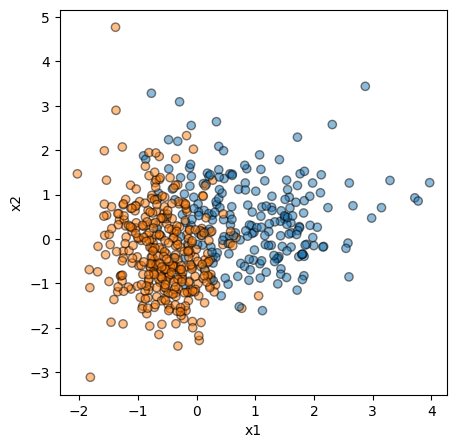

In [ ]:
colors = [sns.color_palette()[0], sns.color_palette()[1]]

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=mpl.colors.ListedColormap(colors), edgecolors="black")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### Add redundancy to increase dataset size

In [ ]:
X1 = X

X_rnd = np.abs(np.random.normal(0,0.01, size = X.shape))
X2 = X + np.multiply(X, X_rnd)

X_rnd = np.abs(np.random.normal(0,0.01, size = X.shape))
X3 = X + np.multiply(X, X_rnd)

X_rnd = np.abs(np.random.normal(0,0.01, size = X.shape))
X4 = X + np.multiply(X, X_rnd)

X_rnd = np.abs(np.random.normal(0,0.01, size = X.shape))
X5 = X + np.multiply(X, X_rnd)

X_rnd = np.abs(np.random.normal(0,0.01, size = X.shape))
X6 = X + np.multiply(X, X_rnd)

X_rnd = np.abs(np.random.normal(0,0.01, size = X.shape))
X7 = X + np.multiply(X, X_rnd)

In [ ]:
X = np.concatenate((X1, X2, X3, X4, X5, X6, X7))
y = np.concatenate((y, y, y, y, y, y, y))

len(X)

3983

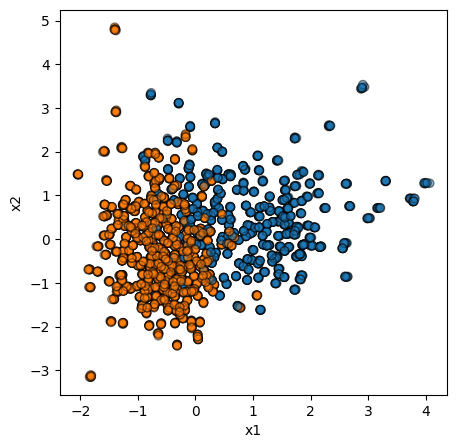

In [ ]:
colors = [sns.color_palette()[0], sns.color_palette()[1]]

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=mpl.colors.ListedColormap(colors), edgecolors="black")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [ ]:
# Divide dataset into batches
num_batches = 6
batch_size = int(len(X)/num_batches)
data = []

for i in range(0, num_batches):
   start_ind = 0
   end_ind = (i+1)*batch_size
   new_data = (X[start_ind:end_ind, :], y[start_ind:end_ind])
   data.append(new_data)

# Test QP SVM solvers

In [ ]:
# general solver parameters
solver_params = {}

solver_params['D_scale'] = 1e-6
solver_params['dt'] = 5
solver_params['num_samples'] = 1000
solver_params['burnin'] = 100
solver_params['alpha'] = 0.05
solver_params['init_scale'] = 1
solver_params['solver'] = 'linalg'
solver_params['gamma'] = 1e-6

solver_params['mute'] = False

### Digital (linalg package)

In [ ]:
X.shape

(3983, 2)

In [ ]:
np.dot(X[0], X[1])

0.7103675276564185

In [ ]:
X, y = data[0]

digital_model = SVM(kernel=linear_kernel, C=10,solver_params=solver_params)
digital_model.fit(X,y)

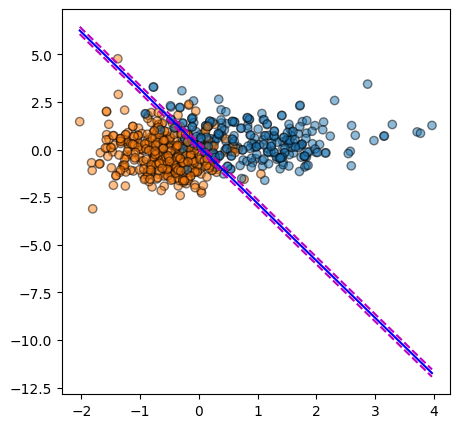

0.9034690799396682

In [ ]:
plot_margin(X, y, digital_model)
accuracy_score(y, digital_model.predict(X))

### Thermodynamic (thermox package)

In [ ]:
solver_params['solver'] = 'therm'

therm_model = SVM(kernel=linear_kernel, C=10.0, solver_params = solver_params)

therm_model.fit(X,y)

0.1702799015045166
Iteration 0: Relative error between solvers = 0.015308225527405739
0.17911633110046388
Iteration 1: Relative error between solvers = 0.003638741560280323
0.18784308815002443
Iteration 2: Relative error between solvers = 0.0010654213838279247
0.1968631000518799
Iteration 3: Relative error between solvers = 0.00416160561144352
0.2054918670654297
Iteration 4: Relative error between solvers = 0.0013776915147900581
0.21474839019775394
Iteration 5: Relative error between solvers = 0.0008351264987140894
0.22421949005126957
Iteration 6: Relative error between solvers = 0.0016193375922739506
0.23388084793090824
Iteration 7: Relative error between solvers = 0.0009674799512140453
0.2435081119537354
Iteration 8: Relative error between solvers = 0.00150758505333215
0.252791337966919
Iteration 9: Relative error between solvers = 0.0010356608545407653
0.263537977218628
Iteration 10: Relative error between solvers = 0.0014845392433926463
0.2726073417663575
Iteration 11: Relative err

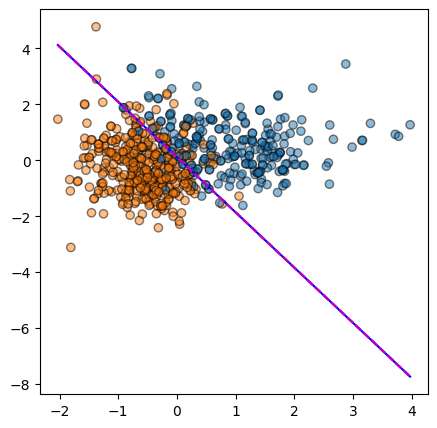

0.8853695324283559

In [ ]:
plot_margin(X, y, therm_model)
accuracy_score(y, therm_model.predict(X))

In [ ]:
accuracy_score(y, therm_model.predict(X)) - accuracy_score(y, digital_model.predict(X))

-0.018099547511312264

In [ ]:
S_therm = (therm_model.fitting_sols > 1e-5).flatten()
a_therm = therm_model.fitting_sols

In [ ]:
print(therm_model.w / therm_model.w[0])
print(therm_model.b / therm_model.w[0])

[1.         0.50660097]
-0.05690414026540361


In [ ]:
print(digital_model.w / digital_model.w[0])
print(digital_model.b / digital_model.w[0])

[1.         0.33337842]
-0.05696895040249222


# Run thermodynamic solver on batches

In [ ]:
solver_params['mute'] = False
solver_params['gamma'] = 1e-6

# compute times
dims, times, params, train_errors, digital_model, therm_model = time_vs_dim(data, solver_params, num_samples=1000)

  0%|          | 0/6 [00:00<?, ?it/s]

0.015244644165039062
Iteration 0: Relative error between solvers = 0.015308225527405739
0.024306617736816402
Iteration 1: Relative error between solvers = 0.003638741560280323
0.034897569656372064
Iteration 2: Relative error between solvers = 0.0010654213838279247
0.0441264362335205
Iteration 3: Relative error between solvers = 0.00416160561144352
0.05510028839111327
Iteration 4: Relative error between solvers = 0.0013776915147900581
0.06368280220031737
Iteration 5: Relative error between solvers = 0.0008351264987140894
0.0730773696899414
Iteration 6: Relative error between solvers = 0.0016193375922739506
0.08198294067382812
Iteration 7: Relative error between solvers = 0.0009674799512140453
0.09147001457214356
Iteration 8: Relative error between solvers = 0.00150758505333215
0.1017679500579834
Iteration 9: Relative error between solvers = 0.0010356608545407653
0.11039027976989747
Iteration 10: Relative error between solvers = 0.0014845392433926463
0.1198008213043213
Iteration 11: Rela

 17%|█▋        | 1/6 [01:22<06:53, 82.66s/it]

0.194498405456543
Iteration 19: Relative error between solvers = 0.0009243625681847334
0.13267771530151368
Iteration 0: Relative error between solvers = 0.03922763094305992
0.14398821449279786
Iteration 1: Relative error between solvers = 0.0075683207251131535
0.15543747329711916
Iteration 2: Relative error between solvers = 0.0015822440618649125
0.16720978927612307
Iteration 3: Relative error between solvers = 0.011925955303013325
0.17850383758544924
Iteration 4: Relative error between solvers = 0.0022914281580597162
0.18972397613525394
Iteration 5: Relative error between solvers = 0.001142716035246849
0.20119159317016605
Iteration 6: Relative error between solvers = 0.0027814288623631
0.2122512760162354
Iteration 7: Relative error between solvers = 0.0013992226449772716
0.22402073097229008
Iteration 8: Relative error between solvers = 0.0025832082610577345
0.23545020103454595
Iteration 9: Relative error between solvers = 0.0019281415734440088
0.2468152980804444
Iteration 10: Relative

 33%|███▎      | 2/6 [09:36<21:37, 324.42s/it]

0.34966121673583994
Iteration 19: Relative error between solvers = 0.0026147954631596804
0.13354841995239258
Iteration 0: Relative error between solvers = 0.0703912228345871
0.14926131820678712
Iteration 1: Relative error between solvers = 0.014666525647044182
0.1652545967102051
Iteration 2: Relative error between solvers = 0.004156387876719236
0.18106476974487307
Iteration 3: Relative error between solvers = 0.006378084886819124
0.19640192031860354
Iteration 4: Relative error between solvers = 0.004366472829133272
0.21217585372924808
Iteration 5: Relative error between solvers = 0.004215516149997711
0.22791473960876468
Iteration 6: Relative error between solvers = 0.004380124155431986
0.2437151374816895
Iteration 7: Relative error between solvers = 0.005216666497290134
0.2593290920257569
Iteration 8: Relative error between solvers = 0.004647337831556797
0.27509038925170903
Iteration 9: Relative error between solvers = 0.008131425827741623
0.29042014884948736
Iteration 10: Relative err

 50%|█████     | 3/6 [34:07<42:23, 847.99s/it]

Iteration 19: Relative error between solvers = 0.01244889572262764
0.12250987815856934
Iteration 0: Relative error between solvers = 0.10561125725507736
0.1449385509490967
Iteration 1: Relative error between solvers = 0.02302442491054535
0.1669490375518799
Iteration 2: Relative error between solvers = 0.008051044307649136
0.19018451881408693
Iteration 3: Relative error between solvers = 0.012958437204360962
0.21285399436950686
Iteration 4: Relative error between solvers = 0.008412804454565048
0.23499537277221683
Iteration 5: Relative error between solvers = 0.007182987406849861
0.25718920326232914
Iteration 6: Relative error between solvers = 0.00829329900443554
0.27890762710571293
Iteration 7: Relative error between solvers = 0.011866683140397072
0.301399003982544
Iteration 8: Relative error between solvers = 0.008581647649407387
0.32399528503417974
Iteration 9: Relative error between solvers = 0.013610752299427986
0.3478291969299317
Iteration 10: Relative error between solvers = 0.00

 67%|██████▋   | 4/6 [1:28:44<1:00:14, 1807.19s/it]

0.17185441780090333
Iteration 0: Relative error between solvers = 0.1531819999217987
0.20821269607543946
Iteration 1: Relative error between solvers = 0.03677710145711899
0.2456555404663086
Iteration 2: Relative error between solvers = 0.01426419336348772
0.2823440284729004
Iteration 3: Relative error between solvers = 0.15064840018749237
0.3191700839996338
Iteration 4: Relative error between solvers = 0.0094747394323349
0.35673690605163577
Iteration 5: Relative error between solvers = 0.008479200303554535
0.39400355911254886
Iteration 6: Relative error between solvers = 0.005115611478686333
0.43290027999877934
Iteration 7: Relative error between solvers = 0.0007235872326418757
0.4706337566375733
Iteration 8: Relative error between solvers = 0.012404815293848515
0.5078260231018067
Iteration 9: Relative error between solvers = 0.02711198851466179
0.5453263263702393
Iteration 10: Relative error between solvers = 0.016306478530168533
0.5859201107025146
Iteration 11: Relative error between

 83%|████████▎ | 5/6 [3:07:35<54:54, 3294.02s/it]  

0.18435470390319825
Iteration 0: Relative error between solvers = 0.21889713406562805
0.2356670722961426
Iteration 1: Relative error between solvers = 0.09953596442937851
0.28742790603637697
Iteration 2: Relative error between solvers = 0.02464926615357399
0.33772580337524416
Iteration 3: Relative error between solvers = 0.02375148981809616
0.3868978881835938
Iteration 4: Relative error between solvers = 0.023400692269206047
0.43725133705139163
Iteration 5: Relative error between solvers = 0.023392103612422943
0.48755042648315433
Iteration 6: Relative error between solvers = 0.023392369970679283
0.5385979118347167
Iteration 7: Relative error between solvers = 0.023392749950289726
0.5897362346649169
Iteration 8: Relative error between solvers = 0.023392749950289726
0.6398829746246336
Iteration 9: Relative error between solvers = 0.023392749950289726
0.6902352313995359
Iteration 10: Relative error between solvers = 0.023392749950289726
0.7401557121276853
Iteration 11: Relative error betw

100%|██████████| 6/6 [5:38:26<00:00, 3384.47s/it]

Iteration 19: Relative error between solvers = 0.023392749950289726


### Plotting

In [ ]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = 10, 5

In [ ]:
times['fit_time_therm']

array([0.19449841, 0.34966122, 0.4313315 , 0.54976212, 0.88267432,
       1.14325367])

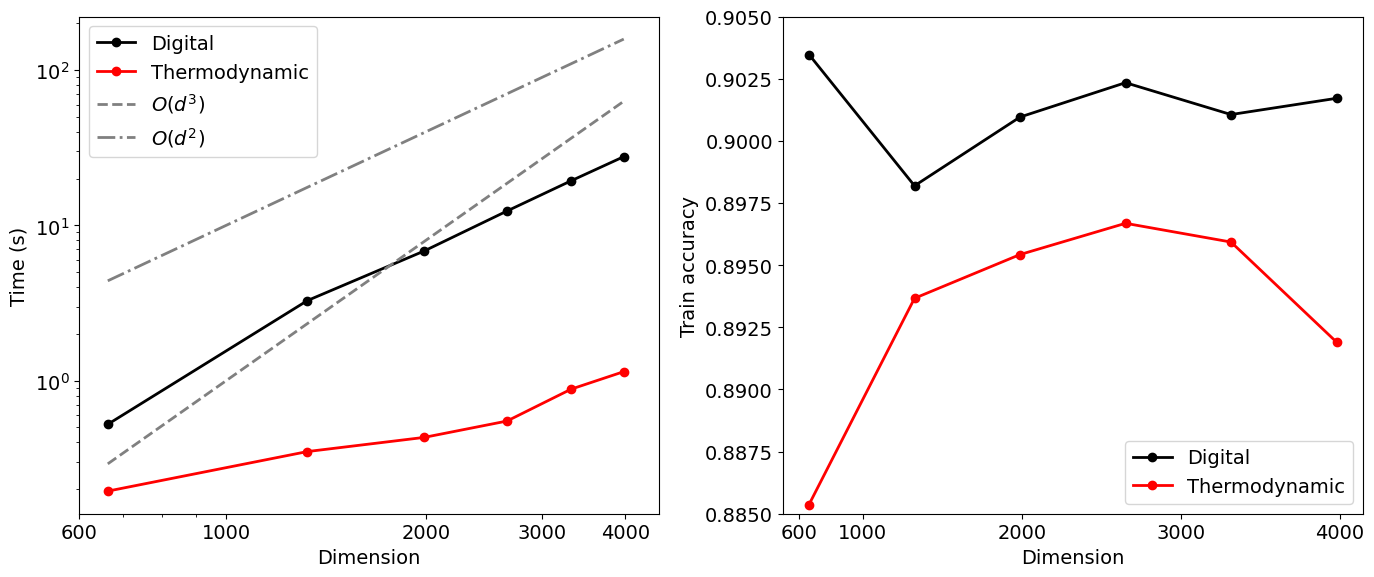

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,6))

ax1.plot(dims, times['fit_time_digital'], label="Digital", color="black", marker='o', lw=2)
ax1.plot(dims, times['fit_time_therm'], label="Thermodynamic", color="red", marker='o', lw=2)
ax1.plot(dims, 0.000000001*np.array(dims) ** 3, label=r"$O(d^3)$", color="grey", lw=2, linestyle='--')
ax1.plot(dims, 0.00001*np.array(dims) ** 2, label=r"$O(d^2)$", color="grey", lw=2, linestyle='-.')
ax1.legend()
ax1.set_xlabel("Dimension")
ax1.set_ylabel("Time (s)")
ax1.set_yscale('log')
ax1.set_xscale('log')
#ax1.set_ylim(1,200)
ax1.set_xlim(600, 4500)

ax2.plot(dims, train_errors['digital'], label="Digital", color="black", marker='o', lw=2)
ax2.plot(dims, train_errors['therm'], label="Thermodynamic", color="red", marker='o', lw=2)
ax2.legend(loc=4)
ax2.set_xlabel("Dimension")
ax2.set_ylabel("Train accuracy")
#ax1.set_yscale('log')
# ax2.set_xscale('log')
ax2.set_ylim(0.885,0.905)

for ax in [ax1, ax2]:  # Replace with your actual axes
    ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style='plain', axis='x')  # Ensure no scientific notation
    ax.set_xticks([600, 1000, 2000, 3000, 4000])  # Custom ticks for clarity

# plt.show()
fig.tight_layout()
plt.savefig('plot.pdf')

In [ ]:
times, dims, train_errors

({'fit_time_digital': array([ 0.52379775,  3.27893496,  6.83872318, 12.36912084, 19.38331747,
         27.69250345]),
  'fit_time_therm': array([0.19449841, 0.34966122, 0.4313315 , 0.54976212, 0.88267432,
         1.14325367])},
 [663, 1326, 1989, 2652, 3315, 3978],
 {'digital': array([0.90346908, 0.89819005, 0.90095525, 0.90233786, 0.90105581,
         0.9017094 ]),
  'therm': array([0.88536953, 0.89366516, 0.89542484, 0.89668175, 0.8959276 ,
         0.89190548])})

In [ ]:
import json

# Your data
data = {
    'fit_time_digital': [0.52379775, 3.27893496, 6.83872318, 12.36912084, 19.38331747, 27.69250345],
    'fit_time_therm': [0.19449841, 0.34966122, 0.4313315, 0.54976212, 0.88267432, 1.14325367],
    'dimensions': [663, 1326, 1989, 2652, 3315, 3978],
    'accuracy_digital': [0.90346908, 0.89819005, 0.90095525, 0.90233786, 0.90105581, 0.9017094],
    'accuracy_therm': [0.88536953, 0.89366516, 0.89542484, 0.89668175, 0.8959276, 0.89190548]
}

# Save to JSON file
with open('data.json', 'w') as f:
    json.dump(data, f)

In [ ]:
# error in normalized parameters
normalized_params_digital = np.array([params['digital'][i] / params['digital'][i][0] for i in range(0, len(params['digital']))])
normalized_params_therm = np.array([params['therm'][i] / params['therm'][i][0] for i in range(0, len(params['therm']))])

(-20.0, -10.0)

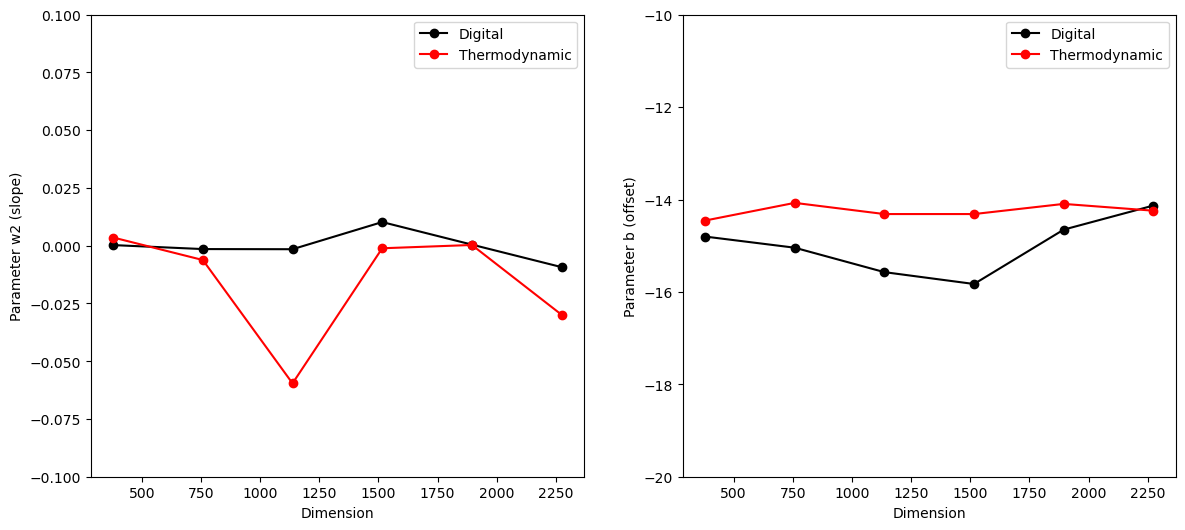

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,6))

ax1.plot(dims, normalized_params_digital[:,1], label="Digital", color="black", marker='o')
ax1.plot(dims, normalized_params_therm[:,1], label="Thermodynamic", color="red", marker='o')
ax1.legend()
ax1.set_xlabel("Dimension")
ax1.set_ylabel("Parameter w2 (slope)")
ax1.set_ylim(-0.1,0.1)

ax2.plot(dims, normalized_params_digital[:,2], label="Digital", color="black", marker='o')
ax2.plot(dims, normalized_params_therm[:,2], label="Thermodynamic", color="red", marker='o')
ax2.legend()
ax2.set_xlabel("Dimension")
ax2.set_ylabel("Parameter b (offset)")
ax2.set_ylim(-20,-10)